<a href="https://colab.research.google.com/github/jinwoo3239/Deepchem/blob/main/Chembl_tutorial.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Chembl tutorial

- ref1, [TeachOpenCADD](https://projects.volkamerlab.org/teachopencadd/all_talktorials.html)
- ref2, [github](https://github.com/StillWork/AIDD-2208-add/blob/main/c_83_4_ChEMBL_Data.ipynb)


In [65]:
!pip install deepchem
!pip install chembl_webresource_client

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [127]:
import os

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import rdkit
from rdkit import Chem
from rdkit.Chem import AllChem, Draw, Descriptors, rdMolDescriptors, PandasTools
from rdkit.Chem.Draw import IPythonConsole

from rdkit.Chem.FilterCatalog import FilterCatalog, FilterCatalogParams

from rdkit.Chem import MACCSkeys
from rdkit.Chem.AllChem import GetMorganFingerprint, GetMorganFingerprintAsBitVect

from rdkit import DataStructs


import deepchem as dc
from chembl_webresource_client.new_client import new_client

plt.rc('font', family='calibri')

In [4]:
print(f'deepchem version = {dc.__version__}')

deepchem version = 2.6.1


In [5]:
target_api = new_client.target # Finding target... target_chembl_id
compound_api = new_client.molecule
activity_api = new_client.activity

## Target search
- selection of `target_chembl_id`

In [6]:
target_query = target_api.search('coronavirus')
targets = pd.DataFrame.from_dict(target_query)
targets[:2]
# selecting target chembl_id

# uniprot_id = 'P00533'
# target_query = target_api.get(target_components__accession=uniprot_id)
# targets = pd.DataFrame.from_dict(target_query)
# targets

,cross_references,organism,pref_name,score,species_group_flag,target_chembl_id,target_components,target_type,tax_id
0,[],Coronavirus,Coronavirus,17.0,False,CHEMBL613732,[],ORGANISM,11119
1,[],SARS coronavirus,SARS coronavirus,15.0,False,CHEMBL612575,[],ORGANISM,227859


In [30]:
target_chembl_id = 'CHEMBL3927'

activities = activity_api.filter(target_chembl_id=target_chembl_id,
                               standard_type='IC50',
                               standard_relation='=')

data = pd.DataFrame.from_dict(activities)
data.head(3)

,activity_comment,activity_id,activity_properties,assay_chembl_id,assay_description,assay_type,assay_variant_accession,assay_variant_mutation,bao_endpoint,bao_format,...,target_organism,target_pref_name,target_tax_id,text_value,toid,type,units,uo_units,upper_value,value
0,None,1480935,[],CHEMBL829584,In vitro inhibitory concentration against SARS...,B,None,None,BAO_0000190,BAO_0000357,...,SARS coronavirus,SARS coronavirus 3C-like proteinase,227859,None,None,IC50,uM,UO_0000065,None,7.2
1,None,1480936,[],CHEMBL829584,In vitro inhibitory concentration against SARS...,B,None,None,BAO_0000190,BAO_0000357,...,SARS coronavirus,SARS coronavirus 3C-like proteinase,227859,None,None,IC50,uM,UO_0000065,None,9.4
2,None,1481061,[],CHEMBL830868,In vitro inhibitory concentration against SARS...,B,None,None,BAO_0000190,BAO_0000357,...,SARS coronavirus,SARS coronavirus 3C-like proteinase,227859,None,None,IC50,uM,UO_0000065,None,13.5


In [31]:
data.columns

# We should check the chembl_id by using compound_api

Index(['activity_comment', 'activity_id', 'activity_properties',
       'assay_chembl_id', 'assay_description', 'assay_type',
       'assay_variant_accession', 'assay_variant_mutation', 'bao_endpoint',
       'bao_format', 'bao_label', 'canonical_smiles', 'data_validity_comment',
       'data_validity_description', 'document_chembl_id', 'document_journal',
       'document_year', 'ligand_efficiency', 'molecule_chembl_id',
       'molecule_pref_name', 'parent_molecule_chembl_id', 'pchembl_value',
       'potential_duplicate', 'qudt_units', 'record_id', 'relation', 'src_id',
       'standard_flag', 'standard_relation', 'standard_text_value',
       'standard_type', 'standard_units', 'standard_upper_value',
       'standard_value', 'target_chembl_id', 'target_organism',
       'target_pref_name', 'target_tax_id', 'text_value', 'toid', 'type',
       'units', 'uo_units', 'upper_value', 'value'],
      dtype='object')

In [32]:
## EDA

data.isnull().sum()
columns = ['assay_chembl_id', 'assay_type', 'canonical_smiles',
           'standard_relation', 'standard_value', 'standard_units', 'molecule_chembl_id']

data = data[columns]
data.shape

(131, 7)

In [33]:
data.standard_units.value_counts()

nM    131
Name: standard_units, dtype: int64

In [34]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 131 entries, 0 to 130
Data columns (total 7 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   assay_chembl_id     131 non-null    object
 1   assay_type          131 non-null    object
 2   canonical_smiles    131 non-null    object
 3   standard_relation   131 non-null    object
 4   standard_value      131 non-null    object
 5   standard_units      131 non-null    object
 6   molecule_chembl_id  131 non-null    object
dtypes: object(7)
memory usage: 7.3+ KB


In [35]:
data = data.astype({'standard_value' : 'float32'})

In [36]:
data.shape

(131, 7)

**Add pIC50 values**  
As you can see the low IC50 values are difficult to read (values are distributed over multiple scales), which is why we convert the IC50 values to pIC50.

In [37]:
def pIC50_converter(IC50):
    # unit = nM
    if IC50 > 1e9:
        IC50 = 1e9
    pIC50 = 9 - np.log10(IC50)
    return pIC50

def activity_converter(pIC50):
    if pIC50 <= 5:
        return 'inactive'

    elif pIC50 > 6:
        return 'active'
    
    else:
        return 'intermediated'

data['pIC50'] = data.standard_value.apply(pIC50_converter)
data['activity'] = data.pIC50.apply(activity_converter)

In [38]:
# lipinski rules
# Mw <= 500, HBA <= 10, HBD <=5, logp <= 5,
# Linpinski rules are satisfied more than 3

def lipinski_rules_df(smiles):
    
    mol = Chem.MolFromSmiles(smiles)

    Mw = Descriptors.MolWt(mol)
    HBA = Descriptors.NumHAcceptors(mol)
    HBD = Descriptors.NumHDonors(mol)
    logp = Descriptors.MolLogP(mol)

    conditions = (sum([Mw, HBA, HBD, logp]) >= 3)

    return pd.Series(data = [Mw, HBA, HBD, logp, conditions],
                     index=['Mw', 'HBA', 'HBD', 'logP', 'linpinski_satisfied'])

In [39]:
lipinski_df = data.canonical_smiles.apply(lipinski_rules_df)

data = pd.concat([data, lipinski_df], axis=1)
data.head()

,assay_chembl_id,assay_type,canonical_smiles,standard_relation,standard_value,standard_units,molecule_chembl_id,pIC50,activity,Mw,HBA,HBD,logP,linpinski_satisfied
0,CHEMBL829584,B,Cc1noc(C)c1CN1C(=O)C(=O)c2cc(C#N)ccc21,=,7200.0,nM,CHEMBL187579,5.142668,intermediated,281.271,5,0,1.89262,True
1,CHEMBL829584,B,O=C1C(=O)N(Cc2ccc(F)cc2Cl)c2ccc(I)cc21,=,9400.0,nM,CHEMBL188487,5.026872,intermediated,415.589,2,0,3.81320,True
2,CHEMBL830868,B,O=C1C(=O)N(CC2COc3ccccc3O2)c2ccc(I)cc21,=,13500.0,nM,CHEMBL185698,4.869666,inactive,421.190,4,0,2.66050,True
3,CHEMBL829584,B,O=C1C(=O)N(Cc2cc3ccccc3s2)c2ccccc21,=,13110.0,nM,CHEMBL426082,4.882397,inactive,293.347,3,0,3.63080,True
4,CHEMBL829584,B,O=C1C(=O)N(Cc2cc3ccccc3s2)c2c1cccc2[N+](=O)[O-],=,2000.0,nM,CHEMBL187717,5.698970,intermediated,338.344,5,0,3.53900,True


In [45]:
columns = ['assay_chembl_id', 'canonical_smiles', 'activity', 'molecule_chembl_id',
           'pIC50', 'Mw', 'HBA', 'HBD', 'logP', 'linpinski_satisfied']

target_molecule_df = data[columns]
target_molecule_df.to_csv('target_molecule_df.csv', index=False)

In [46]:
df = pd.read_csv('target_molecule_df.csv')
df.head()

,assay_chembl_id,canonical_smiles,activity,molecule_chembl_id,pIC50,Mw,HBA,HBD,logP,linpinski_satisfied
0,CHEMBL829584,Cc1noc(C)c1CN1C(=O)C(=O)c2cc(C#N)ccc21,intermediated,CHEMBL187579,5.142668,281.271,5,0,1.89262,True
1,CHEMBL829584,O=C1C(=O)N(Cc2ccc(F)cc2Cl)c2ccc(I)cc21,intermediated,CHEMBL188487,5.026872,415.589,2,0,3.81320,True
2,CHEMBL830868,O=C1C(=O)N(CC2COc3ccccc3O2)c2ccc(I)cc21,inactive,CHEMBL185698,4.869666,421.190,4,0,2.66050,True
3,CHEMBL829584,O=C1C(=O)N(Cc2cc3ccccc3s2)c2ccccc21,inactive,CHEMBL426082,4.882397,293.347,3,0,3.63080,True
4,CHEMBL829584,O=C1C(=O)N(Cc2cc3ccccc3s2)c2c1cccc2[N+](=O)[O-],intermediated,CHEMBL187717,5.698970,338.344,5,0,3.53900,True


## EDA

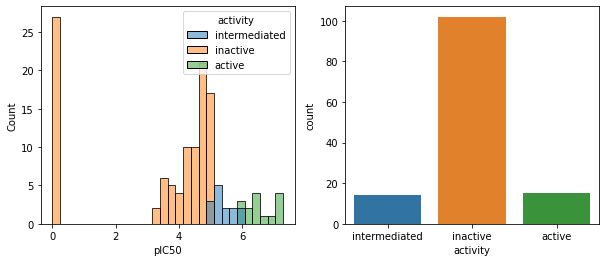

In [47]:
plt.figure(figsize=(10, 4))

plt.subplot(1, 2, 1)
sns.histplot(x='pIC50', data=df, bins=30, hue='activity')

plt.subplot(1, 2, 2)
sns.countplot(x='activity', data=df)
plt.show()

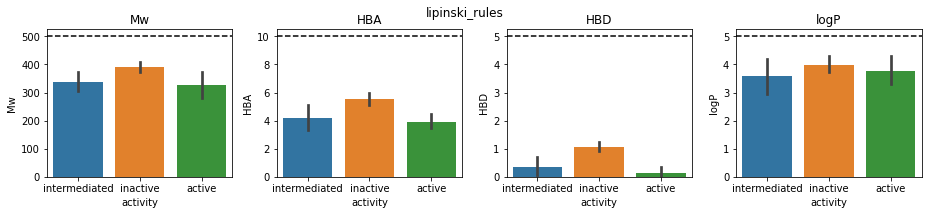

In [48]:
plt.figure(figsize=(13, 3))

plt.subplot(1, 4, 1)
sns.barplot(x='activity', y='Mw', data=df,)
plt.axhline(y=500, color='k', linestyle='--')
plt.title('Mw')

plt.subplot(1, 4, 2)
sns.barplot(x='activity', y='HBA', data=df)
plt.axhline(y=10, color='k', linestyle='--')
plt.title('HBA')

plt.subplot(1, 4, 3)
sns.barplot(x='activity', y='HBD', data=df)
plt.axhline(y=5, color='k', linestyle='--')
plt.title('HBD')

plt.subplot(1, 4, 4)
sns.barplot(x='activity', y='logP', data=df)
plt.axhline(y=5, color='k', linestyle='--')
plt.title('logP')

plt.suptitle('lipinski_rules')
plt.tight_layout()
plt.show()

## Molecular filtering: unwanted substructures
- reference [(TeachOpenCADD)](https://projects.volkamerlab.org/teachopencadd/talktorials/T003_compound_unwanted_substructures.html)


**Unwanted substructures**  
Substructures can be unfavorable, e.g., because they are toxic or reactive, due to unfavorable pharmacokinetic properties, or because they likely interfere with certain assays. Nowadays, drug discovery campaigns often involve high throughput screening. Filtering unwanted substructures can support assembling more efficient screening libraries, which can save time and resources. Brenk et al. (Chem. Med. Chem. (2008), 3, 435-44) have assembled a list of unfavorable substructures to filter their libraries used to screen for compounds to treat neglected diseases. Examples of such unwanted features are nitro groups (mutagenic), sulfates and phosphates (likely resulting in unfavorable pharmacokinetic properties), 2-halopyridines and thiols (reactive). This list of undesired substructures was published in the above mentioned paper and will be used in the practical part of this talktorial.

**Pan Assay Interference Compounds (PAINS)**  
PAINS are compounds that often occur as hits in HTS even though they actually are false positives. PAINS show activity at numerous targets rather than one specific target. Such behavior results from unspecific binding or interaction with assay components. Baell et al. (J. Med. Chem. (2010), 53, 2719-2740) focused on substructures interfering in assay signaling. They described substructures which can help to identify such PAINS and provided a list which can be used for substructure filtering.

In [67]:
df = pd.read_csv('target_molecule_df.csv')
df.head()

,assay_chembl_id,canonical_smiles,activity,molecule_chembl_id,pIC50,Mw,HBA,HBD,logP,linpinski_satisfied
0,CHEMBL829584,Cc1noc(C)c1CN1C(=O)C(=O)c2cc(C#N)ccc21,intermediated,CHEMBL187579,5.142668,281.271,5,0,1.89262,True
1,CHEMBL829584,O=C1C(=O)N(Cc2ccc(F)cc2Cl)c2ccc(I)cc21,intermediated,CHEMBL188487,5.026872,415.589,2,0,3.81320,True
2,CHEMBL830868,O=C1C(=O)N(CC2COc3ccccc3O2)c2ccc(I)cc21,inactive,CHEMBL185698,4.869666,421.190,4,0,2.66050,True
3,CHEMBL829584,O=C1C(=O)N(Cc2cc3ccccc3s2)c2ccccc21,inactive,CHEMBL426082,4.882397,293.347,3,0,3.63080,True
4,CHEMBL829584,O=C1C(=O)N(Cc2cc3ccccc3s2)c2c1cccc2[N+](=O)[O-],intermediated,CHEMBL187717,5.698970,338.344,5,0,3.53900,True


In [68]:
mols = [Chem.MolFromSmiles(mol) for mol in df.canonical_smiles.values]
len(mols)

131

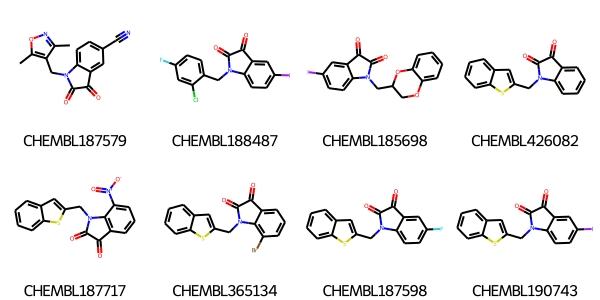

In [69]:
Draw.MolsToGridImage(mols[:8], molsPerRow=4, subImgSize=(150, 150),
                     legends=df.molecule_chembl_id[:8].values.tolist())

In [70]:
# http://rdkit.org/docs/source/rdkit.Chem.rdfiltercatalog.html

# Initialization of structural filter

params = FilterCatalogParams()
params.AddCatalog(FilterCatalogParams.FilterCatalogs.PAINS)

catalog = FilterCatalog(params)

In [82]:
# Search for compounds matched with PAINS

for mol in mols:
    entry = catalog.GetFirstMatch(mol)
    if entry is not None:
        print(entry.GetDescription())
        break

imine_one_A(321)


##  Ligand-based screening: compound similarity


The similar property principle (SPP) as well as the structure-activity relationship (SAR) approaches are based on the assumption that structurally similar molecules have similar properties and, thus, similar biological activity. In this context, virtual screening follows this idea to search for similar molecules in given a set of molecules with known binding affinity and to propose those as potentially new active molecules.

**Molecular fingerprints**

- **Substructure-based fingerprints**

    Molecular fingerprints are a computational representation of molecules that encode chemical and molecular features in the form of `bitstrings, bitvectors or arrays`. Each bit corresponds to a predefined molecular feature or environment, where “1” represents the presence and “0” the absence of a feature. Note that some implementations are count-based. 



- **MACCS fingerprints**

    Molecular ACCess System (MACCS) fingerprints, also termed MACCS structural keys, consist of 166 predefined structural fragments. Each position queries the presence or absence of one particular structural fragment or key.

- **Morgan fingerprints and circular fingerprints**

    This family of fingerprints is based on the Morgan algorithm. The bits correspond to the circular environments of each atom in a molecule. `Extended connectivity fingerprints (ECFP)` are also commonly used fingerprints that are derived using a variant of the Morgan algorithm

,molecule_smiles,molecule_names,ROMol
0,CC1C2C(C3C(C(=O)C(=C(C3(C(=O)C2=C(C4=C1C=CC=C4...,Doxycycline,
1,CC1(C(N2C(S1)C(C2=O)NC(=O)C(C3=CC=C(C=C3)O)N)C...,Amoxicilline,

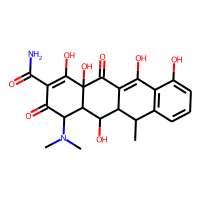
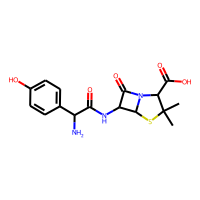

In [89]:
## tutorial

molecule_smiles = [
    "CC1C2C(C3C(C(=O)C(=C(C3(C(=O)C2=C(C4=C1C=CC=C4O)O)O)O)C(=O)N)N(C)C)O",
    "CC1(C(N2C(S1)C(C2=O)NC(=O)C(C3=CC=C(C=C3)O)N)C(=O)O)C",
    "C1=COC(=C1)CNC2=CC(=C(C=C2C(=O)O)S(=O)(=O)N)Cl",
    "CCCCCCCCCCCC(=O)OCCOC(=O)CCCCCCCCCCC",
    "C1NC2=CC(=C(C=C2S(=O)(=O)N1)S(=O)(=O)N)Cl",
    "CC1=C(C(CCC1)(C)C)C=CC(=CC=CC(=CC(=O)O)C)C",
    "CC1(C2CC3C(C(=O)C(=C(C3(C(=O)C2=C(C4=C1C=CC=C4O)O)O)O)C(=O)N)N(C)C)O",
    "CC1C(CC(=O)C2=C1C=CC=C2O)C(=O)O",
]

molecule_names = [
    "Doxycycline",
    "Amoxicilline",
    "Furosemide",
    "Glycol dilaurate",
    "Hydrochlorothiazide",
    "Isotretinoin",
    "Tetracycline",
    "Hemi-cycline D",
]

df = pd.DataFrame({'molecule_smiles' : molecule_smiles, 'molecule_names' : molecule_names})
PandasTools.AddMoleculeColumnToFrame(df, smilesCol='molecule_smiles')
df.head(2)

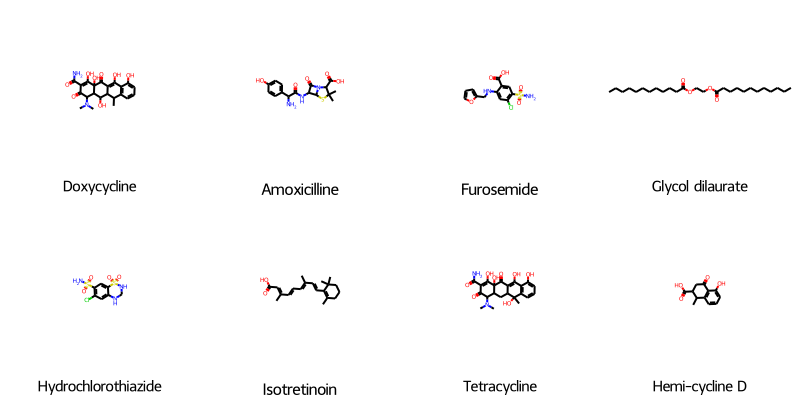

In [103]:
Draw.MolsToGridImage(df.ROMol.tolist(), molsPerRow=4, subImgSize=(200, 200),
                     legends=df.molecule_names.tolist())

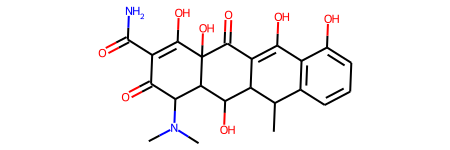

In [104]:
# from rdkit.Chem import MACCkeys

mol = df.ROMol[0]
mol

In [110]:
maccs_fp = MACCSkeys.GenMACCSKeys(mol)
maccs_fp

In [111]:
maccs_fp.ToBitString()

'00000000000000000000000000100000000000000000000000100110000000000010000010101000000011100100110101010100010000101100010000100001000101001001111111101111101011111111110'

In [122]:
# Morgan 

from rdkit.Chem.AllChem import GetMorganFingerprint, GetMorganFingerprintAsBitVect

morgan_fp = GetMorganFingerprint(mol, 2)
# morgan_fp_bit = GetMorganFingerprintAsBitVect(mol, 2, nBits=2048)

In [123]:
 morgan_fp

In [124]:
df['fp_morgan'] = df.ROMol.apply(lambda x: AllChem.GetMorganFingerprint(x, 2))

,molecule_smiles,molecule_names,ROMol,fp_morgan
0,CC1C2C(C3C(C(=O)C(=C(C3(C(=O)C2=C(C4=C1C=CC=C4...,Doxycycline,,<rdkit.DataStructs.cDataStructs.UIntSparseIntV...

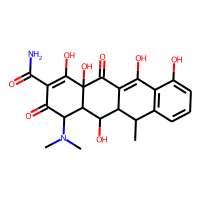

In [126]:
df.head(1)

In [135]:
mol_query = df["fp_morgan"][0]
mol_fp_list = df["fp_morgan"].to_list()
# Calculate similarty values between query and list elements
df["tanimoto"] = DataStructs.BulkTanimotoSimilarity(mol_query, mol_fp_list)
df["dice"] = DataStructs.BulkDiceSimilarity(mol_query, mol_fp_list)

In [137]:
df[['tanimoto', 'dice']]

,tanimoto,dice
0,1.000000,1.000000
1,0.188976,0.317881
2,0.137097,0.241135
3,0.036585,0.070588
4,0.084034,0.155039
5,0.075188,0.139860
6,0.631068,0.773810
7,0.322917,0.488189


## Compound clustering

In [138]:
df = pd.read_csv('target_molecule_df.csv')
df.head()

,assay_chembl_id,canonical_smiles,activity,molecule_chembl_id,pIC50,Mw,HBA,HBD,logP,linpinski_satisfied
0,CHEMBL829584,Cc1noc(C)c1CN1C(=O)C(=O)c2cc(C#N)ccc21,intermediated,CHEMBL187579,5.142668,281.271,5,0,1.89262,True
1,CHEMBL829584,O=C1C(=O)N(Cc2ccc(F)cc2Cl)c2ccc(I)cc21,intermediated,CHEMBL188487,5.026872,415.589,2,0,3.81320,True
2,CHEMBL830868,O=C1C(=O)N(CC2COc3ccccc3O2)c2ccc(I)cc21,inactive,CHEMBL185698,4.869666,421.190,4,0,2.66050,True
3,CHEMBL829584,O=C1C(=O)N(Cc2cc3ccccc3s2)c2ccccc21,inactive,CHEMBL426082,4.882397,293.347,3,0,3.63080,True
4,CHEMBL829584,O=C1C(=O)N(Cc2cc3ccccc3s2)c2c1cccc2[N+](=O)[O-],intermediated,CHEMBL187717,5.698970,338.344,5,0,3.53900,True


,assay_chembl_id,canonical_smiles,activity,molecule_chembl_id,pIC50,Mw,HBA,HBD,logP,linpinski_satisfied,Mol,fp_morgan
0,CHEMBL829584,Cc1noc(C)c1CN1C(=O)C(=O)c2cc(C#N)ccc21,intermediated,CHEMBL187579,5.142668,281.271,5,0,1.89262,True,,<rdkit.DataStructs.cDataStructs.UIntSparseIntV...

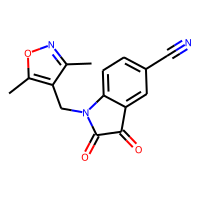

In [140]:
df['Mol'] = df.canonical_smiles.apply(Chem.MolFromSmiles)
df['fp_morgan'] = df.Mol.apply(lambda x: AllChem.GetMorganFingerprint(x, 2))
df.head(1) 

In [ ]:
def tanimoto_dist_matrix(fp_list):
    dissimilarity_matrix = []
    for i in range(1, len(fp_list)):
        similarities = DataStructs.

In [ ]:
ㅠdef tanimoto_distance_matrix(fp_list):
    """Calculate distance matrix for fingerprint list"""
    dissimilarity_matrix = []
    # Notice how we are deliberately skipping the first and last items in the list
    # because we don't need to compare them against themselves
    for i in range(1, len(fp_list)):
        # Compare the current fingerprint against all the previous ones in the list
        similarities = DataStructs.BulkTanimotoSimilarity(fp_list[i], fp_list[:i])
        # Since we need a distance matrix, calculate 1-x for every element in similarity matrix
        dissimilarity_matrix.extend([1 - x for x in similarities])
    return dissimilarity_matrix